<a href="https://colab.research.google.com/github/hrishipoola/Cohort_Metrics_Fictitious_Wine_Shop/blob/main/Cohort_Metrics_for_a_Fictitious_Online_Wine_Shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort Metrics for a Fictitious Online Wine Shop

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Load & Process Data
<br> Orders
<br> Create Quantities
<br> Products
<br> Merge
<br> Revenue
<br> Outliers
4. Cohorts
5. Cohort Index (Time Offset)
6. Cohort Metrics
<br> Retention
<br> Average Revenue
<br> Findings
7. References

## 1. Introduction

Today, let's construct customer time cohorts, specifically first purchase dates, and look at metrics like retention and revenue by cohort. We'll work with [fictitious transactions data](https://github.com/WilliamLamazere/Sales-analysis-toyDataSet) of roughly 340,000 transactions dating from March 1, 2021 to February 28, 2022 (time machine not included). The product and seller context aren't immediately available. For the purpose of this exercise and given the nature of the data, let's assume transactions for an online wine shop. In this case, time cohort analysis can help us understand how retention, quantity, price, and revenue evolve both over the customer lifetime due to product quality, operations, and support and over the product lifetime due to onboarding and customer success. 

To construct cohorts, we'll need purchase history by unique customer id. The orders data set contains client ids, product ids, and purchase dates, while the products data set contains prices and product ids. We would also like to understand revenue by cohort. However, since we only have prices and not quantities, we'll randomly generate quantities based on a right-skewed distribution as often seen in real transactions data and calculate revenue in order to simulate realistic revenue data. Let's merge these two data sets together on product id to get what we need.  

We'll create customer cohorts based on their initial purchase month and a cohort index (time offset) of the difference in months of their subsequent purchases from initial purchase month. Finally, we'll compare and visualize cohort metrics. We'll calculate retention, or the proportion of customers in each cohort that return in subsequent months. We'll also look at cohort revenue. At the end, we'll walk through high-level findings on how the new customer base, retention, and average revenue varies over time and areas to be investigated further. 


## 2. Install & Import Packages

In [27]:
import pandas as pd
import numpy as np
from numpy.random import normal, seed
from numpy.random import choice 
import datetime as dt
from datetime import date, timedelta
from scipy import stats
import statsmodels.api as sm
import random
from random import sample
from scipy.stats import norm
from scipy.stats import skewnorm # to create right-skewed distribution

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')

import io

In [28]:
# Mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Load & Process Data

### Orders

In [29]:
url = 'https://raw.githubusercontent.com/WilliamLamazere/Sales-analysis-toyDataSet/master/transactions.csv'
orders = pd.read_csv(url)

# Format
orders.date = orders.date.str.replace('[A-Za-z_]', '').str.strip() # Remove alpha and _ characters 
orders['date'] = pd.to_datetime(orders['date']).dt.floor('d')
orders.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10,s_18746,c_4450
1,2_226,2022-02-03,s_159142,c_277
2,1_374,2021-09-23,s_94290,c_4270
3,0_2186,2021-10-17,s_105936,c_4597
4,0_1351,2021-07-17,s_63642,c_1242


In [30]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     337016 non-null  object        
 1   date        337016 non-null  datetime64[ns]
 2   session_id  337016 non-null  object        
 3   client_id   337016 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 10.3+ MB


In [31]:
print('Dates range from {} to {}.'.format(min(orders.date.dt.date), max(orders.date.dt.date))) 

Dates range from 2021-03-01 to 2022-02-28.


### Create Quantities

In [32]:
size = orders.shape[0]
size

337016

Create right-skewed normal distribution using skewnorm

Text(0.5, 1.0, 'Distribution of Random Quantities')

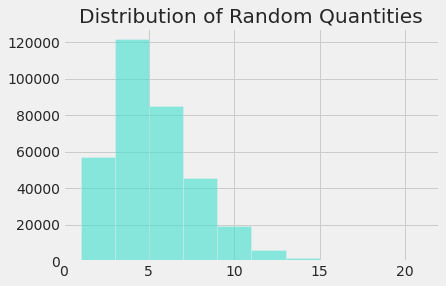

In [33]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html
seed(1111)
size = orders.shape[0]
max_value = 20
skewness = 12  

quantity = skewnorm.rvs(a = skewness, loc=max_value, size=size)  # generate random values with skew

quantity = quantity - min(quantity) # Shift the set so the minimum value is 1.
quantity = quantity / max(quantity) # Standadize all the values between 0 and 1. 
quantity = quantity * max_value # Multiply the standardized values by the maximum value
quantity = quantity + 1
quantity = quantity.astype(int)

plt.hist(quantity, color='turquoise', alpha=0.6)
plt.title('Distribution of Random Quantities')

In [34]:
orders['quantity'] = quantity
orders.head()

,id_prod,date,session_id,client_id,quantity
0,0_1483,2021-04-10,s_18746,c_4450,7
1,2_226,2022-02-03,s_159142,c_277,6
2,1_374,2021-09-23,s_94290,c_4270,5
3,0_2186,2021-10-17,s_105936,c_4597,5
4,0_1351,2021-07-17,s_63642,c_1242,8


### Products

In [35]:
url = 'https://raw.githubusercontent.com/WilliamLamazere/Sales-analysis-toyDataSet/master/products.csv'
products = pd.read_csv(url)
products = products.query('price > 0') # filter for positive prices
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [36]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


### Merge

In [37]:
# Merge orders and products
df = orders.merge(products, on ='id_prod',how = 'outer')
df.dropna(inplace=True)
df.head()

,id_prod,date,session_id,client_id,quantity,price,categ
0,0_1483,2021-04-10,s_18746,c_4450,7.0,4.99,0.0
1,0_1483,2021-10-18,s_106741,c_1576,2.0,4.99,0.0
2,0_1483,2021-11-14,s_119491,c_182,4.0,4.99,0.0
3,0_1483,2021-07-30,s_69222,c_1196,6.0,4.99,0.0
4,0_1483,2021-03-30,s_13545,c_2890,7.0,4.99,0.0


### Revenue

In [38]:
df['revenue'] = df['quantity'] * df['price']
df.head() 

,id_prod,date,session_id,client_id,quantity,price,categ,revenue
0,0_1483,2021-04-10,s_18746,c_4450,7.0,4.99,0.0,34.93
1,0_1483,2021-10-18,s_106741,c_1576,2.0,4.99,0.0,9.98
2,0_1483,2021-11-14,s_119491,c_182,4.0,4.99,0.0,19.96
3,0_1483,2021-07-30,s_69222,c_1196,6.0,4.99,0.0,29.94
4,0_1483,2021-03-30,s_13545,c_2890,7.0,4.99,0.0,34.93


### Outliers

Let's remove outlier revenues (beyond 3 standard deviations). 

Text(0.5, 1.0, 'Distribution of Revenue')

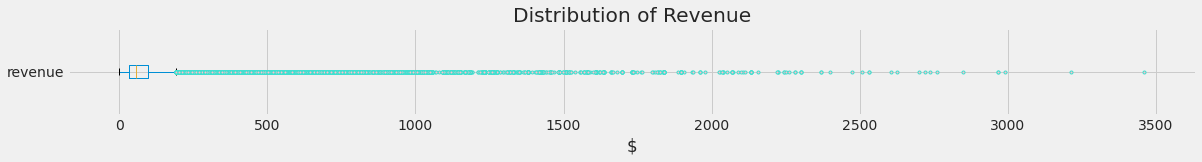

In [39]:
# Box plot: distribution is skewed with higher end outliers 
square = dict(markerfacecolor='pink', markeredgecolor='turquoise', marker='.')
df.revenue.plot(kind='box', vert=False, flierprops=square, figsize=(18,1.5))
plt.xlabel('$')
plt.title('Distribution of Revenue')

Text(0.5, 11.11999999999999, '$')

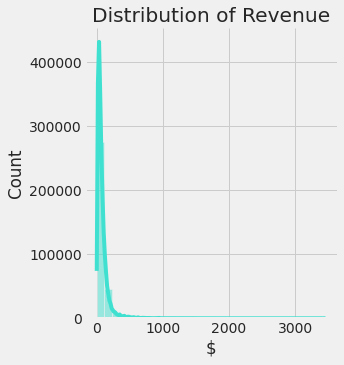

In [40]:
# Plot distribution
sns.displot(df['revenue'],bins=30, kde=True, color='turquoise')
plt.title('Distribution of Revenue')
plt.xlabel('$')

In [41]:
# Remove outliers (beyond 3 standard deviations)
z = np.abs(stats.zscore(df['revenue']))
df_filtered = df[(z < 3)]
outliers = df[(z > 3)] # Keep the outliers as a separate dataframe in case we want to explore them

print('There are {} outliers.'.format(outliers.shape[0]))

There are 5756 outliers.


Text(0.5, 1.0, 'Distribution of Revenue (Ex-Outliers)')

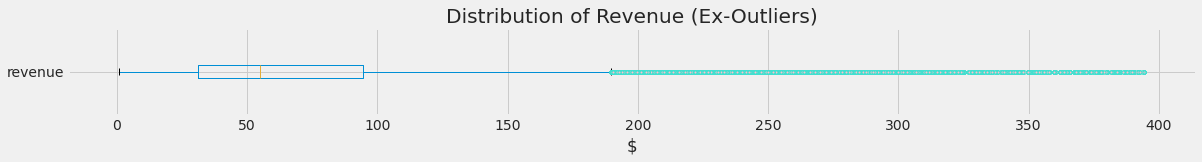

In [42]:
# Distribution with outliers removed
square = dict(markerfacecolor='pink', markeredgecolor='turquoise', marker='.')
df_filtered.revenue.plot(kind='box', vert=False, flierprops=square, figsize=(18,1.5))
plt.xlabel('$')
plt.title('Distribution of Revenue (Ex-Outliers)')

Text(0.5, 11.11999999999999, '$')

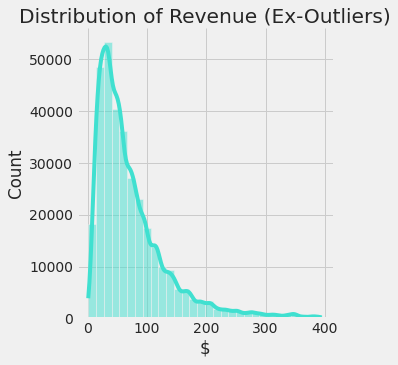

In [43]:
# Plot distribution
sns.displot(df_filtered['revenue'],bins=30, kde=True, color='turquoise')
plt.title('Distribution of Revenue (Ex-Outliers)')
plt.xlabel('$')

In [44]:
df = df_filtered

In [45]:
df.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
quantity      0
price         0
categ         0
revenue       0
dtype: int64

## 4. Cohorts

In [46]:
def get_month(x): return dt.datetime(x.year, x.month, 1) # truncates date to first day of month
df['purchase_month'] = df['date'].apply(get_month)
grouping = df.groupby('client_id')['purchase_month']
df['cohort_month'] = grouping.transform('min') # assign lowest invoice month number to each customer
df.head()

,id_prod,date,session_id,client_id,quantity,price,categ,revenue,purchase_month,cohort_month
0,0_1483,2021-04-10,s_18746,c_4450,7.0,4.99,0.0,34.93,2021-04-01,2021-03-01
1,0_1483,2021-10-18,s_106741,c_1576,2.0,4.99,0.0,9.98,2021-10-01,2021-03-01
2,0_1483,2021-11-14,s_119491,c_182,4.0,4.99,0.0,19.96,2021-11-01,2021-03-01
3,0_1483,2021-07-30,s_69222,c_1196,6.0,4.99,0.0,29.94,2021-07-01,2021-03-01
4,0_1483,2021-03-30,s_13545,c_2890,7.0,4.99,0.0,34.93,2021-03-01,2021-03-01


## 5. Cohort Index (Time Offset)

In [47]:
def get_date_int(df, column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

purchase_year, purchase_month, _ = get_date_int(df, 'purchase_month')
cohort_year, cohort_month, _ = get_date_int(df, 'cohort_month' )

years_diff = purchase_year - cohort_year
months_diff = purchase_month - cohort_month

df['cohort_index'] = years_diff*12 + months_diff + 1 # convert total difference to months, first month marked as 1
df.head()

,id_prod,date,session_id,client_id,quantity,price,categ,revenue,purchase_month,cohort_month,cohort_index
0,0_1483,2021-04-10,s_18746,c_4450,7.0,4.99,0.0,34.93,2021-04-01,2021-03-01,2
1,0_1483,2021-10-18,s_106741,c_1576,2.0,4.99,0.0,9.98,2021-10-01,2021-03-01,8
2,0_1483,2021-11-14,s_119491,c_182,4.0,4.99,0.0,19.96,2021-11-01,2021-03-01,9
3,0_1483,2021-07-30,s_69222,c_1196,6.0,4.99,0.0,29.94,2021-07-01,2021-03-01,5
4,0_1483,2021-03-30,s_13545,c_2890,7.0,4.99,0.0,34.93,2021-03-01,2021-03-01,1


In [54]:
df.to_csv('sales_transactions.csv', index=False)

## 6. Cohort Metrics

### Retention

In [48]:
grouping = df.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['client_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='client_id')
cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2021-03-01,5571.0,4092.0,4037.0,4125.0,4067.0,4010.0,4191.0,3698.0,4198.0,4255.0,4180.0,4123.0
2021-04-01,1463.0,812.0,796.0,819.0,828.0,765.0,682.0,887.0,841.0,842.0,822.0,NaN
2021-05-01,686.0,319.0,351.0,352.0,307.0,292.0,344.0,342.0,334.0,341.0,NaN,NaN
2021-06-01,341.0,137.0,149.0,156.0,140.0,156.0,168.0,160.0,142.0,NaN,NaN,NaN
2021-07-01,191.0,75.0,59.0,59.0,75.0,69.0,85.0,72.0,NaN,NaN,NaN,NaN
2021-08-01,135.0,53.0,40.0,55.0,53.0,57.0,49.0,NaN,NaN,NaN,NaN,NaN
2021-09-01,83.0,28.0,31.0,26.0,29.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01,29.0,11.0,9.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01,35.0,11.0,13.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(64.9, 0.5, 'Cohort Month')

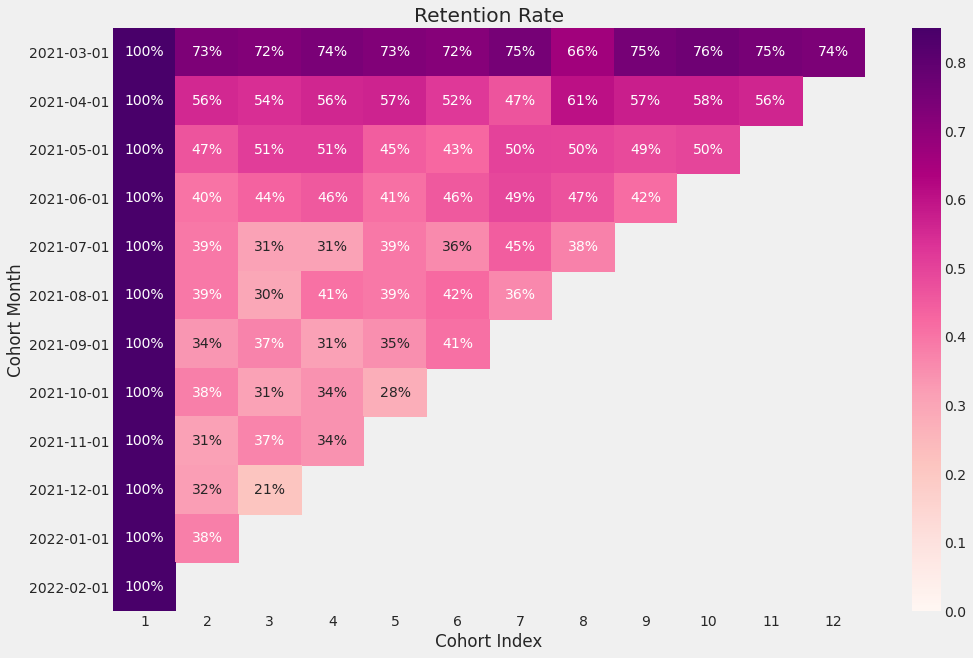

In [49]:
cohort_sizes = cohort_counts.iloc[:,0] # first column is cohort size
retention = cohort_counts.divide(cohort_sizes, axis=0) # divide counts by size along rows
retention.index = retention.index.date

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(data=retention, annot=True, vmin=0.0, vmax=0.85, fmt='.0%', cmap='RdPu')
plt.title('Retention Rate')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')

As expected, the first month's retention is 100% because the number of active customers in the first month is the size of the cohort. 

Text(0.5, 0, 'Cohort Index')

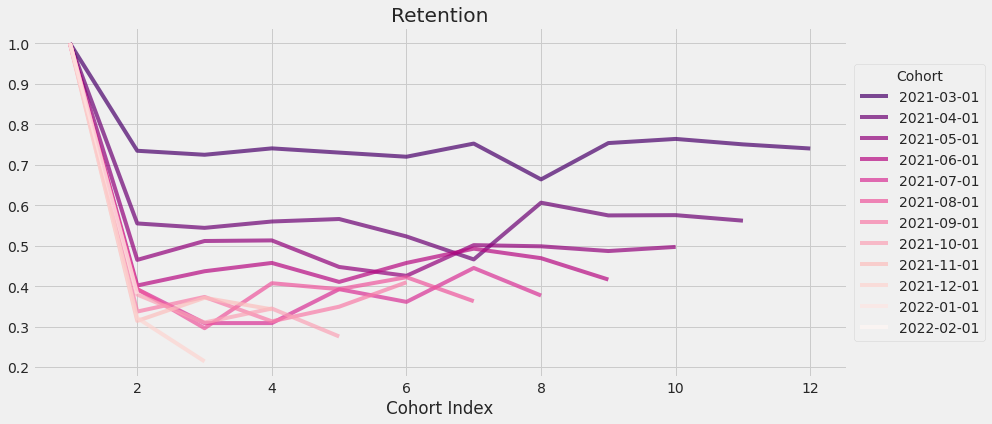

In [53]:
retention.T.plot(cmap='RdPu_r', alpha=0.7,figsize=(13,6))
plt.legend(title='Cohort', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Retention')
plt.xlabel('Cohort Index')

The line plot makes the differences and dropoffs mentioned above more visible.

### Average Revenue

Text(64.9, 0.5, 'Cohort Month')

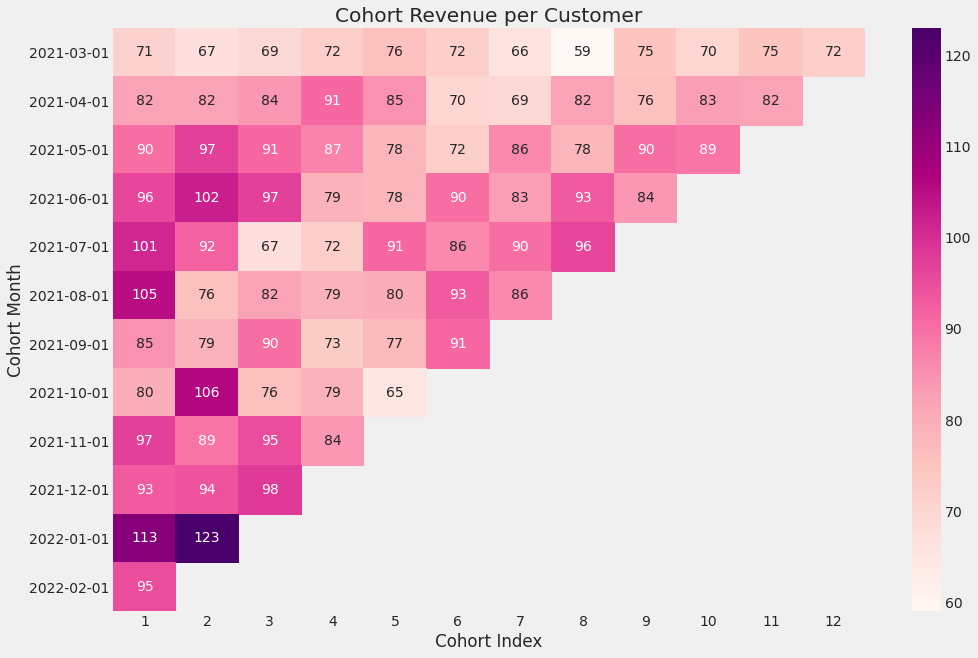

In [51]:
grouping = df.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['revenue'].mean()
cohort_data = cohort_data.reset_index()
cohort_revenue = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='revenue').round()
cohort_revenue.index = cohort_revenue.index.date

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(data=cohort_revenue, annot=True, fmt='g', cmap='RdPu')
plt.title('Cohort Revenue per Customer')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')

Text(0, 0.5, '$')

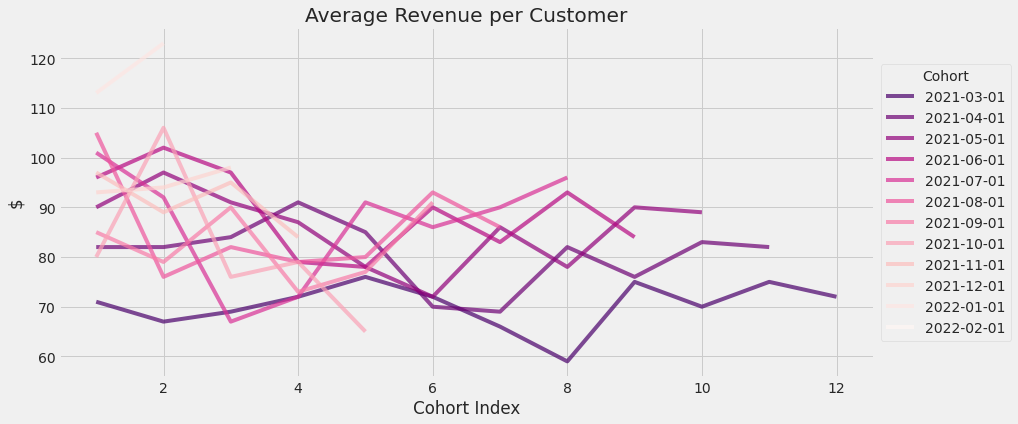

In [52]:
cohort_revenue.T.plot(cmap='RdPu_r', alpha=0.7,figsize=(13,6))
plt.legend(title='Cohort', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average Revenue per Customer')
plt.xlabel('Cohort Index')
plt.ylabel('$')

### Findings

**Customer Count** 
<br>The new customer base (cohort size) declines after the first cohort. 

**Retention**
<br>Retention rates in the first couple of cohorts are notably higher than the other cohorts. Retention drops off signicantly in the 2nd and 3rd month for later cohorts, but, generally remains steady after that. First cohort customers ('early adopters') remain loyal. The significant decline in 2nd and 3rd month retention in later cohorts could be due to onboarding, customer success, marketing campaigns, or other reasons and should be investigated. 

**Average Revenue**
<br>Despite a higher retention rate, earlier cohorts tend to generate less revenue and vice versa. The lower revenue per customer in earlier cohorts could be stem from the fact that a large proportion of the larger earlier cohorts are buying lower priced wine. The effect of marketing campaigns or upselling / cross-selling promotions should also be investigated. 

## 7. References

https://learn.datacamp.com/courses/customer-segmentation-in-python

https://medium.com/analytics-for-humans/a-beginners-guide-to-cohort-analysis-the-most-actionable-and-underrated-report-on-google-c0797d826bf4

https://neilpatel.com/blog/cohort-and-multi-touch-attribution/

https://github.com/WilliamLamazere/Sales-analysis-toyDataSet

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html